In [1]:
import xml.etree.ElementTree as ET

# Parse the mzML file
mzml_file = '../data/2309SPP_0001_A1.mzML'

# Define the namespace (mzML files use namespaces)
namespace = {'mzml': 'http://psi.hupo.org/ms/mzml'}

# Parse and count spectra
tree = ET.parse(mzml_file)
root = tree.getroot()

# Find all spectrum elements
spectra = root.findall('.//mzml:spectrum', namespace)
num_spectra = len(spectra)

print(f"Number of spectra in the file: {num_spectra}")

# Optional: Get some additional info about the spectra
if num_spectra > 0:
    print(f"\nFirst spectrum ID: {spectra[0].get('id')}")
    print(f"Last spectrum ID: {spectra[-1].get('id')}")

Number of spectra in the file: 9349

First spectrum ID: sample=1 period=1 cycle=1 experiment=1
Last spectrum ID: sample=1 period=1 cycle=8756 experiment=1


Total spectra: 9349

Datapoints per spectrum statistics:
  Mean: 2122.97
  Median: 2002.00
  Std Dev: 2123.62
  Min: 1
  Max: 37147
  Total datapoints: 19847621

Quartiles:
  25th percentile: 47.00
  75th percentile: 3492.00


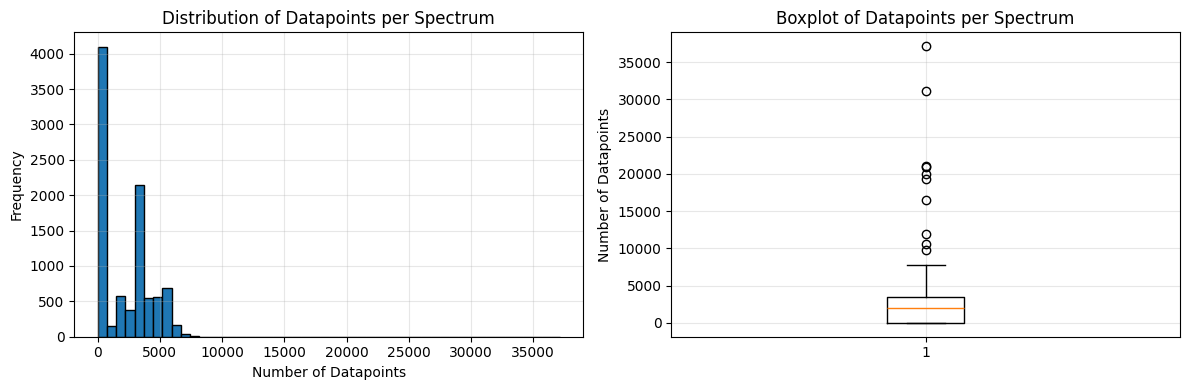

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Count datapoints in each spectrum
datapoint_counts = []

for spectrum in spectra:
    # Find binary data arrays (m/z and intensity arrays)
    binary_arrays = spectrum.findall('.//mzml:binaryDataArray', namespace)
    
    # Get the number of datapoints from the defaultArrayLength attribute
    default_array_length = spectrum.get('defaultArrayLength')
    if default_array_length:
        datapoint_counts.append(int(default_array_length))

datapoint_counts = np.array(datapoint_counts)

# Statistical analysis
print(f"Total spectra: {len(datapoint_counts)}")
print(f"\nDatapoints per spectrum statistics:")
print(f"  Mean: {np.mean(datapoint_counts):.2f}")
print(f"  Median: {np.median(datapoint_counts):.2f}")
print(f"  Std Dev: {np.std(datapoint_counts):.2f}")
print(f"  Min: {np.min(datapoint_counts)}")
print(f"  Max: {np.max(datapoint_counts)}")
print(f"  Total datapoints: {np.sum(datapoint_counts)}")

# Quartiles
print(f"\nQuartiles:")
print(f"  25th percentile: {np.percentile(datapoint_counts, 25):.2f}")
print(f"  75th percentile: {np.percentile(datapoint_counts, 75):.2f}")

# Distribution visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(datapoint_counts, bins=50, edgecolor='black')
plt.xlabel('Number of Datapoints')
plt.ylabel('Frequency')
plt.title('Distribution of Datapoints per Spectrum')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(datapoint_counts, vert=True)
plt.ylabel('Number of Datapoints')
plt.title('Boxplot of Datapoints per Spectrum')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Inspecting spectrum index: 3376
Spectrum ID: sample=1 period=1 cycle=2952 experiment=1
Number of datapoints: 5637

Extracted 5637 m/z values and 5637 intensity values

First 10 datapoints:
m/z             Intensity      
------------------------------
60.0360         64.00          
60.0371         0.00           
60.0392         0.00           
60.0403         107.00         
60.0414         10724.00       
60.0425         46340.00       
60.0436         107508.00      
60.0447         109594.00      
60.0458         60772.00       
60.0468         13755.00       


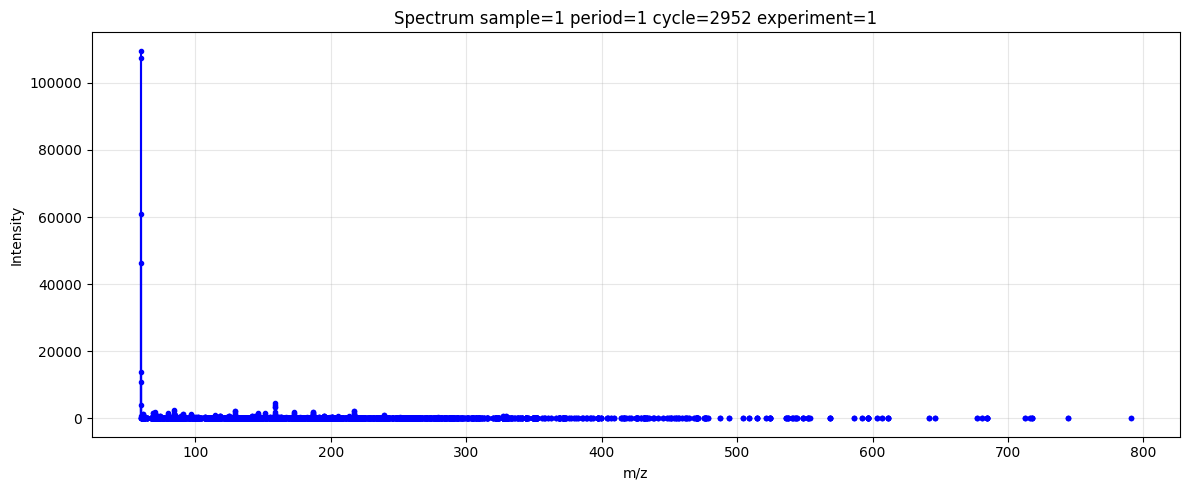

In [3]:
import base64
import struct
import zlib

# Select a random spectrum
random_idx = np.random.randint(0, len(spectra))
random_spectrum = spectra[random_idx]

print(f"Inspecting spectrum index: {random_idx}")
print(f"Spectrum ID: {random_spectrum.get('id')}")
print(f"Number of datapoints: {random_spectrum.get('defaultArrayLength')}")

# Find binary data arrays (m/z and intensity)
binary_arrays = random_spectrum.findall('.//mzml:binaryDataArray', namespace)

mz_array = None
intensity_array = None

for binary_array in binary_arrays:
    # Check what type of data this is (m/z or intensity)
    cv_params = binary_array.findall('.//mzml:cvParam', namespace)
    
    is_mz = any(param.get('name') == 'm/z array' for param in cv_params)
    is_intensity = any(param.get('name') == 'intensity array' for param in cv_params)
    
    # Check compression and precision
    is_compressed = any(param.get('name') == 'zlib compression' for param in cv_params)
    is_64bit = any(param.get('name') == '64-bit float' for param in cv_params)
    
    # Get the binary data
    binary_elem = binary_array.find('.//mzml:binary', namespace)
    if binary_elem is not None:
        encoded_data = binary_elem.text
        decoded_data = base64.b64decode(encoded_data)
        
        # Decompress if needed
        if is_compressed:
            decoded_data = zlib.decompress(decoded_data)
        
        # Unpack binary data
        fmt = 'd' if is_64bit else 'f'  # double or float
        num_values = len(decoded_data) // (8 if is_64bit else 4)
        values = struct.unpack(f'<{num_values}{fmt}', decoded_data)
        
        if is_mz:
            mz_array = np.array(values)
        elif is_intensity:
            intensity_array = np.array(values)

# Display the data
print(f"\nExtracted {len(mz_array)} m/z values and {len(intensity_array)} intensity values")
print(f"\nFirst 10 datapoints:")
print(f"{'m/z':<15} {'Intensity':<15}")
print("-" * 30)
for i in range(min(10, len(mz_array))):
    print(f"{mz_array[i]:<15.4f} {intensity_array[i]:<15.2f}")

# Plot the spectrum
plt.figure(figsize=(12, 5))
plt.stem(mz_array, intensity_array, linefmt='b-', markerfmt='b.', basefmt=' ')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title(f'Spectrum {random_spectrum.get("id")}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Filtering results:
  Original datapoints: 5637
  Non-zero datapoints: 2902
  Removed: 2735 (48.52%)

First 10 non-zero datapoints:
m/z             Intensity      
------------------------------
60.0360         64.00          
60.0403         107.00         
60.0414         10724.00       
60.0425         46340.00       
60.0436         107508.00      
60.0447         109594.00      
60.0458         60772.00       
60.0468         13755.00       
60.0479         4002.00        
60.0490         582.00         


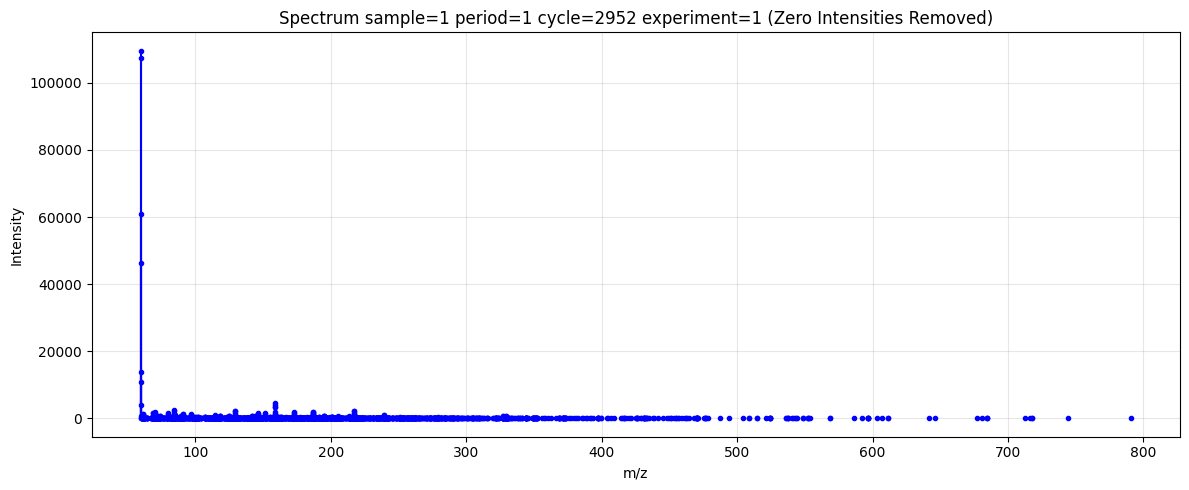

In [4]:
# Remove datapoints with zero intensity
non_zero_mask = intensity_array > 0
mz_filtered = mz_array[non_zero_mask]
intensity_filtered = intensity_array[non_zero_mask]

print(f"\nFiltering results:")
print(f"  Original datapoints: {len(mz_array)}")
print(f"  Non-zero datapoints: {len(mz_filtered)}")
print(f"  Removed: {len(mz_array) - len(mz_filtered)} ({100 * (len(mz_array) - len(mz_filtered)) / len(mz_array):.2f}%)")

# Display filtered data
print(f"\nFirst 10 non-zero datapoints:")
print(f"{'m/z':<15} {'Intensity':<15}")
print("-" * 30)
for i in range(min(10, len(mz_filtered))):
    print(f"{mz_filtered[i]:<15.4f} {intensity_filtered[i]:<15.2f}")

# Plot the filtered spectrum
plt.figure(figsize=(12, 5))
plt.stem(mz_filtered, intensity_filtered, linefmt='b-', markerfmt='b.', basefmt=' ')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title(f'Spectrum {random_spectrum.get("id")} (Zero Intensities Removed)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()